#### Building CNN to Detect Facial Key Points

In [68]:
import torchvision
import torch.nn as nn
import torch
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [70]:
#!git clone https://github.com/udacity/P1_Facial_Keypoints.git

In [71]:
class FaceData(Dataset):
    def __init__(self,df):
        super(FaceData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __len__(self):
        return len(self.df)
    def __getitem__(self,indx):
        img_path = 'data/data/training/' + self.df.iloc[indx,0]
        img = cv2.imread(img_path)/255.
        keypoints = deepcopy(self.df.iloc[indx,1:].tolist())
        keypoints_x = (np.array(keypoints[0::2])/img.shape[1]).tolist()
        keypoints_y = (np.array(keypoints[1::2])/img.shape[0]).tolist()
        keypoints_2 = keypoints_x+keypoints_y
        keypoints_2 = torch.tensor(keypoints_2)
        img = self.preprocess_input(img)
        
        return img, keypoints_2
    def preprocess_input(self,img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        
        return img.to(device)
    def load_image(self,indx):
        img_path = 'data/data/training/' + self.df.iloc[indx,0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
        img = cv2.resize(img, (224,224))
        
        return img


In [72]:
data = pd.read_csv('data/data/updated_training_frames_keypoints.csv')

In [73]:
data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Angelo_Reyes_22.jpg,61,80,58,95,58,108,58,120,58,...,98,136,107,139,95,139,91,139,85,136
1,Albert_Brooks_12.jpg,67,134,69,144,72,154,77,165,79,...,123,176,131,176,123,178,120,181,115,181
2,Daniel_Radcliffe_02.jpg,35,57,35,62,35,67,35,72,35,...,53,80,56,81,51,81,50,81,48,81
3,Christopher_Walken_20.jpg,126,107,126,122,130,133,134,148,141,...,163,152,178,156,167,160,160,159,156,159
4,Cristina_Saralegui_31.jpg,53,78,53,87,53,95,55,104,57,...,87,110,93,113,87,115,83,115,81,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Agbani_Darego_02.jpg,37,53,37,58,38,63,38,68,39,...,59,75,62,77,59,78,57,78,54,78
996,Colin_Powell_51.jpg,47,109,51,124,54,135,58,150,65,...,135,162,143,159,135,162,132,166,124,166
997,Carla_Gugino_32.jpg,19,58,19,64,22,70,23,76,26,...,54,75,58,77,54,77,52,77,49,77
998,Alma_Powell_42.jpg,68,78,65,87,66,94,68,100,70,...,77,105,84,107,77,107,73,107,72,105


In [74]:
train_data, test_data  = train_test_split(data,test_size=0.2,random_state=101)

In [75]:
train_dataset = FaceData(train_data.reset_index(drop=True))
test_dataset = FaceData(test_data.reset_index(drop=True))

In [76]:
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [77]:
def build_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential( nn.Conv2d(512,512,3),
                                  nn.MaxPool2d(2),
                                  nn.Flatten())
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid())
    loss_function = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    return model.to(device), loss_function, optimizer

In [78]:
model, loss_function,optimizer = build_model()

In [79]:
def train_batch(images,keypoints,model, loss_function, optimizer):
    model.train()
    optimizer.zero_grad()
    _keypoints=model(images.to(device))
    loss_value = loss_function(_keypoints, keypoints.to(device))
    loss_value.backward()
    optimizer.step()
    
    return loss_value.item()
     

In [80]:
@torch.no_grad()
def validate_batch(images, keypoints, model, loss_functio):
    model.eval()
    _keypoints = model(images.to(device))
    loss_value = loss_functio(_keypoints, keypoints.to(device))
    
    return _keypoints, loss_value.item()

In [81]:
train_loss, test_loss = [], []

In [82]:
for epoch in range(50):
    print(f"Epoch {epoch+ 1}:")
    epoch_train_loss_value, epoch_test_loss_value = 0, 0
    for ix, (images,keypoints) in enumerate(iter(train_loader)):
        loss_value = train_batch(images, keypoints, model, loss_function,optimizer)
        epoch_train_loss_value += loss_value
    
    epoch_train_loss_value /= (ix+1)
    print(f"Train Loss Value: {epoch_train_loss_value:0.3f}")
    
    for ix, (images,keypoints) in enumerate(iter(test_loader)):
        keypoints, loss_value = validate_batch(images,keypoints, model, loss_function)
        epoch_test_loss_value+= loss_value
    
    epoch_test_loss_value /= (ix+1)
    print(f"Test Loss Value: {epoch_test_loss_value:0.3f}")
    
    train_loss.append(epoch_train_loss_value)
    test_loss.append(epoch_test_loss_value)
    print("<--------------------------->")    

Epoch 1:
Train Loss Value: 0.072
Test Loss Value: 0.047
<--------------------------->
Epoch 2:
Train Loss Value: 0.056
Test Loss Value: 0.039
<--------------------------->
Epoch 3:
Train Loss Value: 0.048
Test Loss Value: 0.035
<--------------------------->
Epoch 4:
Train Loss Value: 0.043
Test Loss Value: 0.031
<--------------------------->
Epoch 5:
Train Loss Value: 0.039
Test Loss Value: 0.029
<--------------------------->
Epoch 6:
Train Loss Value: 0.037
Test Loss Value: 0.028
<--------------------------->
Epoch 7:
Train Loss Value: 0.036
Test Loss Value: 0.026
<--------------------------->
Epoch 8:
Train Loss Value: 0.035
Test Loss Value: 0.031
<--------------------------->
Epoch 9:
Train Loss Value: 0.035
Test Loss Value: 0.034
<--------------------------->
Epoch 10:
Train Loss Value: 0.033
Test Loss Value: 0.027
<--------------------------->
Epoch 11:
Train Loss Value: 0.031
Test Loss Value: 0.026
<--------------------------->
Epoch 12:
Train Loss Value: 0.029
Test Loss Value: 0

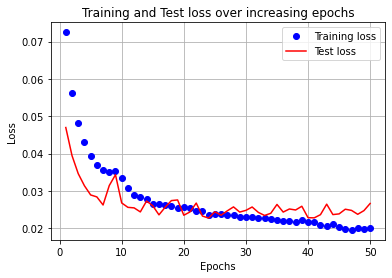

In [83]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

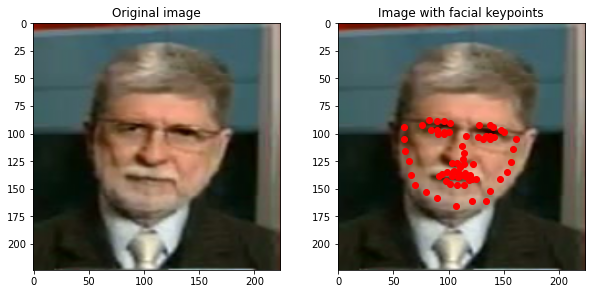

In [105]:
ix = 20
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_image(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()